# Decision Trees

This notebook will demonstrate an application of Decision Trees on the [IBMEmployeeAttrition](https://github.com/Madison-Bunting/INDE-577/blob/main/IBMEmployeeAttrition.csv) dataset.

In [91]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice end formatting
from sklearn.metrics import roc_curve, auc

#importing the dataset as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/Madison-Bunting/INDE-577/main/IBMEmployeeAttrition.csv",
                index_col=0)

Preprocess the data by removing variables with zero variance (as uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook.

In [92]:
#Drop variables with zero variance: EmployeeCount, Over18, and StandardHours
df.drop('EmployeeCount', axis = 1, inplace = True)
df.drop('Over18', axis = 1, inplace = True)
df.drop('StandardHours', axis = 1, inplace = True)

Correlated variables will impact decision tree outputs, so those should be dropped as well. As uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook, we should drop Job Level, Total Working Years, Years in Current Role, Years with Current Manager, and Percent Salary Hike.

In [93]:
#Dropping variables listed above that are correlated
df_final = df.drop(['JobLevel','TotalWorkingYears','YearsInCurrentRole', 'YearsWithCurrManager' , 'PercentSalaryHike'], axis=1)
#Confirm those variables were sucessfully dropped
df_final

,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion
Age,,,,,,,,,,,,,,,,,,,,,
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,...,19479,8,Yes,3,1,0,0,1,6,0
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,...,24907,1,No,4,4,1,3,3,10,1
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,...,2396,6,Yes,3,2,0,3,3,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,...,23159,1,Yes,3,3,0,3,3,8,3
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,...,16632,9,No,3,4,1,3,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,Male,...,12290,4,No,3,3,1,3,3,5,0
39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,Male,...,21457,4,No,3,1,1,5,3,7,1
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,Male,...,5174,1,Yes,4,2,1,0,3,6,0


## Pre-Processing
Before we can run logistic regression, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

In [94]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['BusinessTravel'] = le.fit_transform(res_df['BusinessTravel'])
    res_df['Department'] = le.fit_transform(res_df['Department'])
    res_df['Education'] = le.fit_transform(res_df['Education'])
    res_df['EducationField'] = le.fit_transform(res_df['EducationField'])
    res_df['JobRole'] = le.fit_transform(res_df['JobRole'])
    res_df['Gender'] = le.fit_transform(res_df['Gender'])
    res_df['MaritalStatus'] = le.fit_transform(res_df['MaritalStatus'])
    res_df['OverTime'] = le.fit_transform(res_df['OverTime'])
    res_df['Attrition'] = le.fit_transform(res_df['Attrition'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with logistic regression and standardize them.

In [95]:
#Selecting features
X = encoded_df.drop(['Attrition'],axis =1)
y = encoded_df['Attrition']
y

Age
41    1
49    0
37    1
33    0
27    0
     ..
36    0
39    0
27    0
49    0
34    0
Name: Attrition, Length: 1470, dtype: int32

In [96]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply decision trees, the data must be split into "training" and "test" data.

In [97]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [98]:
#Instantiate the model, run with gini
dt = DecisionTreeClassifier(max_depth=4, random_state=1,criterion ='gini')
#Fit the model with data
dt.fit(X_train,y_train)

dt_score_train = dt.score(X_train, y_train)
print("Training score: ", dt_score_train)
dt_score_test = dt.score(X_test, y_test)
print("Testing score: ",dt_score_test)

y_pred = dt.predict_proba(X_test)[:, 1]

Training score:  0.8784029038112523
Testing score:  0.845108695652174


In [99]:
#Instantiate a new instance of the model, run with entropy
dt1 = DecisionTreeClassifier(max_depth=4, random_state=1,criterion ='entropy')
#Fit the model to the data
dt1.fit(X_train,y_train)

dt1_score_train = dt1.score(X_train, y_train)
print("Training score:", dt1_score_train)
dt1_score_test = dt1.score(X_test, y_test)
print("Testing score:",dt1_score_test)

y_pred = dt1.predict_proba(X_test)[:, 1]

Training score: 0.8702359346642469
Testing score: 0.8369565217391305


# Performance Analysis
The next step is to conduct a performance analysis of the model. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve.

In [100]:
#Compare the predictions for each model
y_pred_gini = dt.predict(X_test)
print("Gini Accuracy:", accuracy_score(y_test,y_pred_gini))

y_pred_entropy= dt1.predict(X_test)
print("Entropy Accuracy:", accuracy_score(y_test,y_pred_entropy))

Gini Accuracy: 0.845108695652174
Entropy Accuracy: 0.8369565217391305


Text(0.5, 257.44, 'Predicted label')

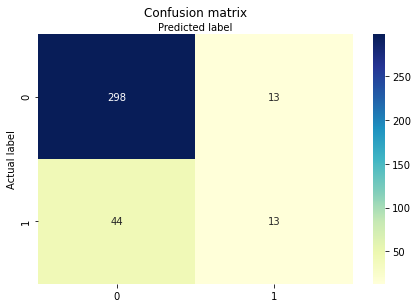

In [101]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gini)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [102]:
#Print a nicely formatted report
print(classification_report(y_test,y_pred_gini))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       311
           1       0.50      0.23      0.31        57

    accuracy                           0.85       368
   macro avg       0.69      0.59      0.61       368
weighted avg       0.81      0.85      0.82       368



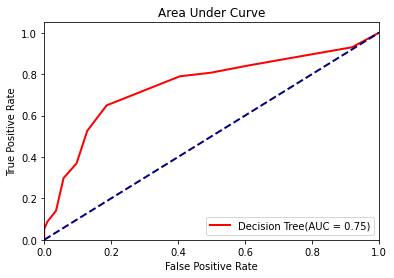

In [105]:
#Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red',
         lw=2, label='Decision Tree(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Curve')
plt.legend(loc = 4)
plt.show()